In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# -------------------- Parameters you can tweak --------------------
lambda_m = 1.0  # wavelength (meters). With λ=1 m, baselines in meters == wavelengths.
positions_m = np.array([[0.0, 0.0],
                        [1.0, 0.0],
                        [2.0, 0.0]])  # three antennas along x, 1 m apart

# Aperture (ground) matrix settings
grid_size = 65        # pixels per axis (odd so center is clear)
meters_per_pixel = 0.1  # spatial resolution of the grid in meters/pixel
# ------------------------------------------------------------------

In [47]:
# Helper: map continuous meters to nearest pixel index
def to_index(x_m, x0_m, dx_m, n):
    return int(round((x_m - x0_m) / dx_m)) % n

# Build empty aperture matrix
A = np.zeros((grid_size, grid_size), dtype=float)
# Define grid extent so that all antennas fit with some margin
half_span_m = (grid_size // 2) * meters_per_pixel
x0 = -half_span_m  # left/bottom edge in meters
y0 = -half_span_m

In [48]:
# Build coordinate axes (meters)
x_axis = np.linspace(x0, -x0, grid_size, endpoint=False)
y_axis = np.linspace(y0, -y0, grid_size, endpoint=False)

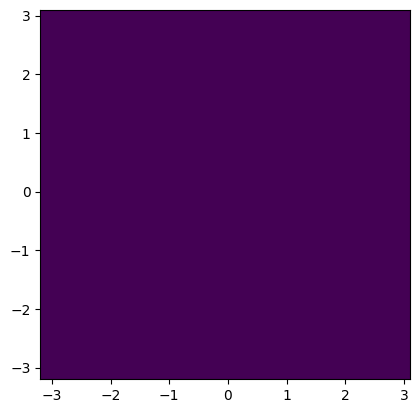

In [49]:
plt.imshow(A, origin="lower", extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]], interpolation="nearest")
plt.show()

In [50]:
# Place antennas as delta=1 at nearest pixel
for (xm, ym) in positions_m:
    j = to_index(xm, x0, meters_per_pixel, grid_size)  # x -> col
    i = to_index(ym, y0, meters_per_pixel, grid_size)  # y -> row
    A[i, j] += 1.0

In [51]:
# 2D autocorrelation via FFT: R = ifft2(FFT(A) * conj(FFT(A)))
# (Autocorrelation = convolution with a 180°-rotated copy; FFT method handles that efficiently.)
FA = np.fft.fft2(A)
R = np.fft.ifft2(FA * np.conj(FA)).real
R = np.fft.fftshift(R)

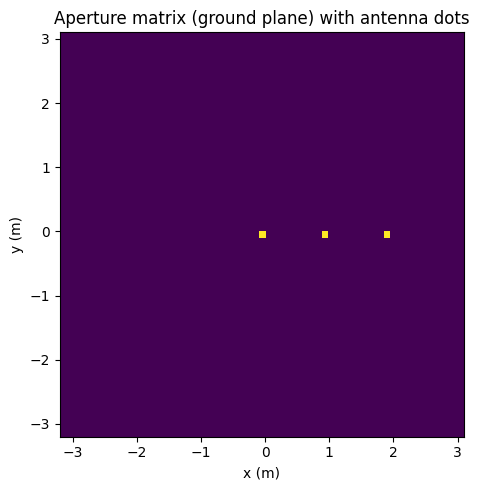

In [52]:

# ----------- 1) Show aperture matrix with antenna dots -----------
plt.figure(figsize=(5, 5))
plt.title("Aperture matrix (ground plane) with antenna dots")
plt.imshow(A, origin="lower", extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]], interpolation="nearest")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()

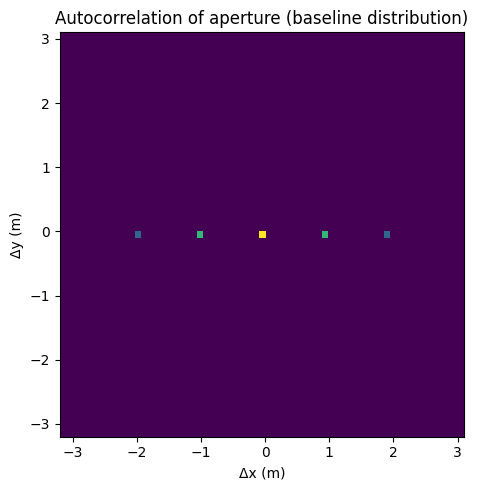

In [53]:
# ----------- 2) Show autocorrelation (baseline distribution image) -----------
plt.figure(figsize=(5, 5))
plt.title("Autocorrelation of aperture (baseline distribution)")
plt.imshow(R, origin="lower", extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]], interpolation="nearest")
plt.xlabel("Δx (m)")
plt.ylabel("Δy (m)")
plt.tight_layout()
plt.show()

In [54]:
# ----------- 3) Compute uv points explicitly from pairwise differences -----------
# Baseline vectors (meters): all pairwise differences r_j - r_i
pairs = []
uv_points = []
n_ant = positions_m.shape[0]
for i in range(n_ant):
    for j in range(n_ant):
        if i == j:
            continue
        dx = positions_m[j,0] - positions_m[i,0]
        dy = positions_m[j,1] - positions_m[i,1]
        # Convert to wavelengths
        u = dx / lambda_m
        v = dy / lambda_m
        pairs.append(((i, j), (dx, dy)))
        uv_points.append((u, v))

uv_points = np.array(uv_points)

# Unique uv (rounded for display)
uv_unique = np.unique(np.round(uv_points, 6), axis=0)

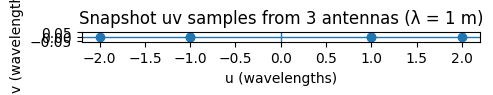

In [55]:
# ----------- 4) Scatter plot of uv samples (snapshot) -----------
plt.figure(figsize=(5, 5))
plt.title("Snapshot uv samples from 3 antennas (λ = 1 m)")
plt.scatter(uv_points[:,0], uv_points[:,1])
plt.xlabel("u (wavelengths)")
plt.ylabel("v (wavelengths)")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

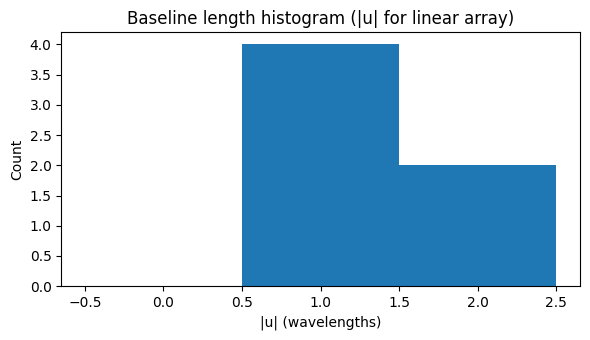

In [56]:
# ----------- 5) 1D baseline histogram along x (since y=0 here) -----------
# Extract Δx baselines, convert to wavelengths, and histogram
dx_waves = uv_points[:,0]  # already in wavelengths
plt.figure(figsize=(6, 3.5))
plt.title("Baseline length histogram (|u| for linear array)")
abs_u = np.abs(dx_waves)
bins = np.arange(-0.5, abs_u.max()+1.5, 1.0)
plt.hist(abs_u, bins=bins)
plt.xlabel("|u| (wavelengths)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [57]:
# ----------- 6) Print a friendly summary -----------
# All unordered baselines (i<j) and their lengths
baseline_list = []
for i in range(n_ant):
    for j in range(i+1, n_ant):
        dx = positions_m[j,0] - positions_m[i,0]
        dy = positions_m[j,1] - positions_m[i,1]
        b_m = np.hypot(dx, dy)
        baseline_list.append(((i, j), b_m, (dx/lambda_m, dy/lambda_m)))

print("Antenna positions (m):")
for k, (xm, ym) in enumerate(positions_m):
    print(f"  Antenna {k}: (x={xm:.3f}, y={ym:.3f})")

print("\nUnordered baselines (i<j):")
for ((i,j), b_m, (u,v)) in baseline_list:
    print(f"  {i}-{j}: length = {b_m:.3f} m  = {b_m/lambda_m:.3f} λ ;  uv = ({u:.3f}, {v:.3f})")

print("\nNotes:")
print("- The autocorrelation image shows peaks at every (Δx, Δy) baseline vector.")
print("- The uv scatter plot lists both positive and negative baselines (i→j and j→i).")
print("- With λ=1 m and 1 m spacing, you get |u| = 1 and 2 wavelengths (two of 1λ, one of 2λ).")
print("- Earth rotation would sweep each point into an arc/ellipse in uv; adding more antennas fills uv more densely.")

Antenna positions (m):
  Antenna 0: (x=0.000, y=0.000)
  Antenna 1: (x=1.000, y=0.000)
  Antenna 2: (x=2.000, y=0.000)

Unordered baselines (i<j):
  0-1: length = 1.000 m  = 1.000 λ ;  uv = (1.000, 0.000)
  0-2: length = 2.000 m  = 2.000 λ ;  uv = (2.000, 0.000)
  1-2: length = 1.000 m  = 1.000 λ ;  uv = (1.000, 0.000)

Notes:
- The autocorrelation image shows peaks at every (Δx, Δy) baseline vector.
- The uv scatter plot lists both positive and negative baselines (i→j and j→i).
- With λ=1 m and 1 m spacing, you get |u| = 1 and 2 wavelengths (two of 1λ, one of 2λ).
- Earth rotation would sweep each point into an arc/ellipse in uv; adding more antennas fills uv more densely.


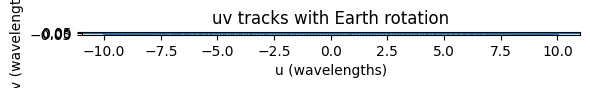

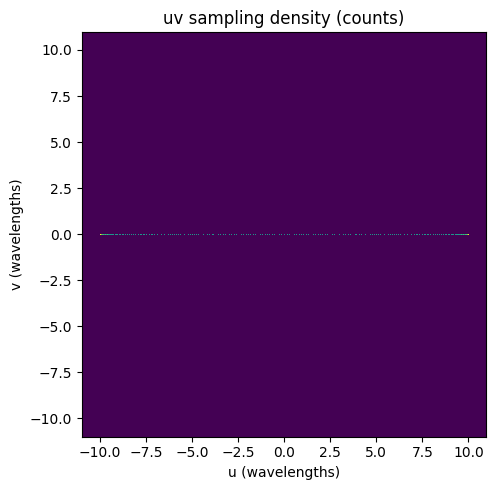

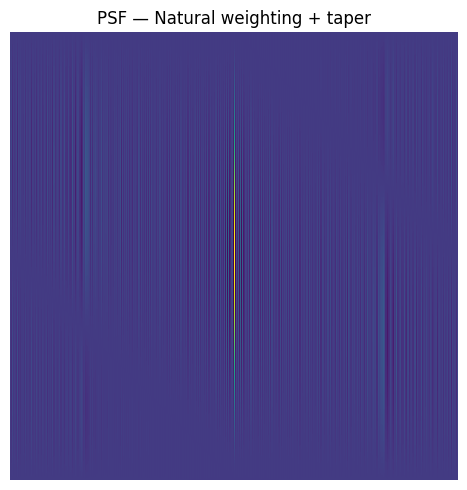

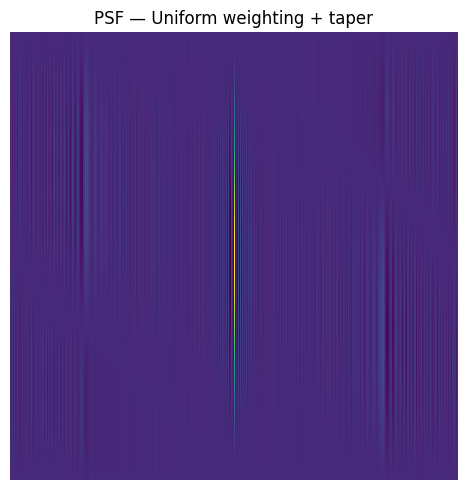

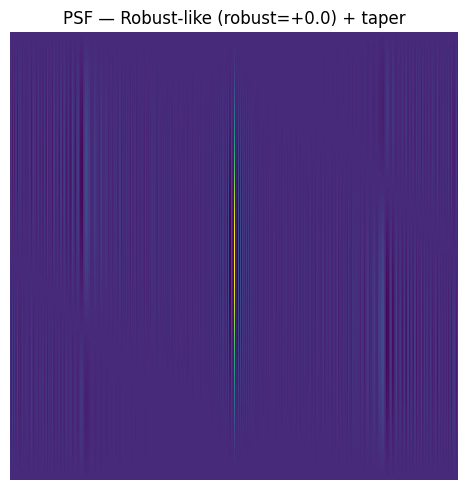

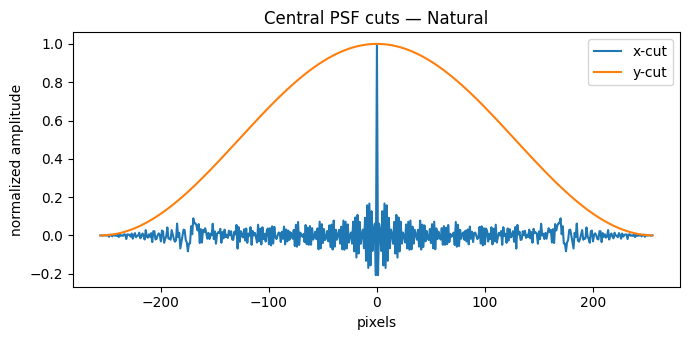

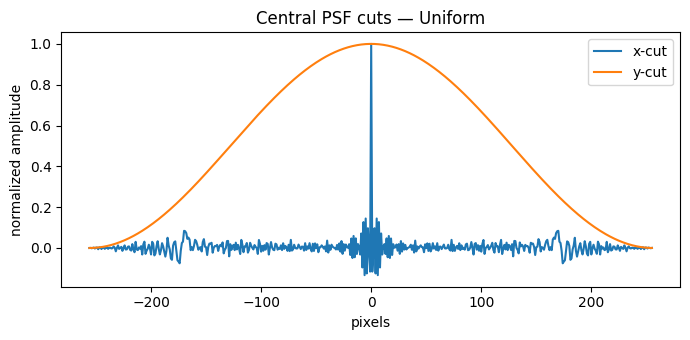

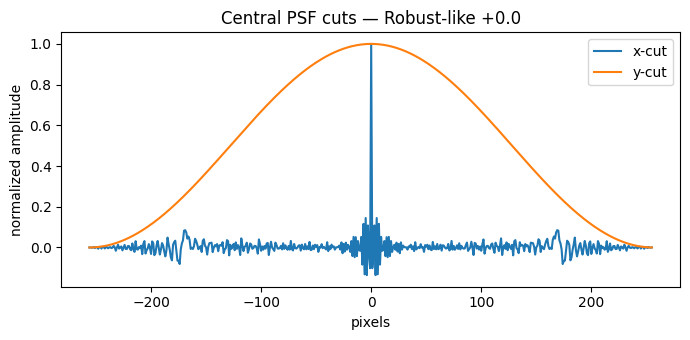

Summary:
- Natural PSF FWHM ~ 0.83 px (x), 256.00 px (y)
- Uniform PSF FWHM ~ 0.90 px (x), 256.00 px (y)
- Robust-like PSF FWHM ~ 0.91 px (x), 256.00 px (y)
Tip: more antennas + longer tracks ⇒ denser uv ⇒ cleaner PSF (lower sidelobes).
     Uniform sharpens the main lobe (better nominal resolution) but raises noise;
     Natural lowers noise but broadens the main lobe; Robust balances the two.


In [26]:
# Interferometry sandbox: uv tracks with Earth rotation + weighting/taper effects on the synthesized beam
# Edit the parameters in the block below and re-run to explore.
#
# What you get:
# 1) uv tracks over time for your antenna layout and source declination
# 2) Sampling masks on a uv grid
# 3) Synthesized beams (PSFs) for Natural, Uniform, and a simple Robust-like weighting
# 4) Optional Gaussian uv-taper (controls sidelobes vs resolution)
#
# Notes
# - Coordinates: x = East (m), y = North (m), z = Up (m). Default arrays lie in the ground plane (z=0).
# - Wavelength units: u,v are in wavelengths (divide baselines by λ).
# - The "Robust-like" control approximates Briggs robust weighting for illustration (not CASA's exact formula).

import numpy as np
import matplotlib.pyplot as plt

# ----------------------- PARAMETERS (edit me) -----------------------
# Antenna positions in meters: list of (x_E, y_N, z_U).
# Try a triangle, a small Y, a mini-random layout, etc.
positions_m = np.array([
    [0.0,   0.0, 0.0],
    [10.0,  0.0, 0.0],
    [5.0,  8.66, 0.0],  # ~equilateral triangle side ~10 m
])

lambda_m = 1.0               # wavelength (m). With λ=1 m, meters == wavelengths
site_lat_deg = 6.7           # site latitude (e.g., Accra region ~6.7°N)
source_dec_deg = 0.0         # source declination (°). Try 0, 20, -30, etc.
hour_angle_hours = (-6, 6)   # simulate HA from -6h to +6h
n_time = 241                  # number of time samples along the track

# uv grid (imaging) parameters
uv_grid_size = 512           # grid size for uv (power of 2 works well)
uv_margin_frac = 0.10        # extra margin beyond max |u|,|v| to avoid edge effects

# Weighting and taper controls
use_taper = True
taper_fwhm_klambda = 0.8     # Gaussian uv-taper FWHM in kilo-wavelengths (kλ). Increase to blur more.
robust_like = 0.0            # -2 ~ uniform, 0 ~ mid, +2 ~ natural (illustrative, not exact Briggs)
# -------------------------------------------------------------------


# ----------------------- Helper functions --------------------------
def baselines_from_positions(pos_m):
    """Return list of baseline vectors (E,N,U) for all unordered i<j pairs."""
    bl = []
    n = pos_m.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            b = pos_m[j] - pos_m[i]
            bl.append((i, j, b))
    return bl

def uv_from_baseline_ENU(b_enu_m, dec_rad, H_rad, lam_m):
    """
    Project a baseline (E,N,U) into (u,v) over hour angle H for a given declination dec.
    Using a common small-field convention (Thompson et al. style) with ENU components.
    """
    bE, bN, bU = b_enu_m
    # u and v in wavelengths (divide by λ)
    u = ( bE * np.sin(H_rad) + bN * np.cos(H_rad) ) / lam_m
    v = ( -bE * np.sin(dec_rad) * np.cos(H_rad) + bN * np.sin(dec_rad) * np.sin(H_rad) + bU * np.cos(dec_rad) ) / lam_m
    return u, v

def make_uv_grid(u_samples, v_samples, nu=512, margin_frac=0.1):
    """Build a uv grid covering the sample extents with a small margin; return grid, axes, and nearest-neighbor indices."""
    umax = np.max(np.abs(u_samples)); vmax = np.max(np.abs(v_samples))
    umax *= (1 + margin_frac); vmax *= (1 + margin_frac)
    # keep square field for nice PSF pixels
    umax = vmax = max(umax, vmax)
    u_axis = np.linspace(-umax, umax, nu, endpoint=False)
    v_axis = np.linspace(-vmax, vmax, nu, endpoint=False)
    du = u_axis[1] - u_axis[0]; dv = v_axis[1] - v_axis[0]
    # indexer
    def to_idx(vals, axis_min, d, n):
        idx = np.floor((vals - axis_min) / d).astype(int)
        idx = np.clip(idx, 0, n-1)
        return idx
    iu = to_idx(u_samples, u_axis[0], du, nu)
    iv = to_idx(v_samples, v_axis[0], dv, nu)
    return (u_axis, v_axis), (iu, iv)

def accumulate_uv_counts(iu, iv, nu=512):
    M = np.zeros((nu, nu), dtype=float)
    for k in range(iu.size):
        M[iv[k], iu[k]] += 1.0
    return M

def symmetrize_uv(M):
    """Enforce Hermitian-like even symmetry on real weights for a real PSF."""
    return 0.5*(M + np.flipud(np.fliplr(M)))

def gaussian_taper(u_axis, v_axis, fwhm_kl):
    """Gaussian uv-taper with circular FWHM in kλ. Returns 2D taper array normalized to 1 at center."""
    if fwhm_kl is None or fwhm_kl <= 0:
        return None
    # Convert FWHM to sigma (in wavelengths). kλ to λ.
    fwhm = fwhm_kl * 1e3
    sigma = fwhm / (2.0*np.sqrt(2.0*np.log(2.0)))
    U, V = np.meshgrid(u_axis, v_axis)
    R2 = (U**2 + V**2)
    T = np.exp(-0.5 * R2 / (sigma**2))
    T /= T.max() if T.max() != 0 else 1.0
    return T

def robust_like_weights(counts, robust=0.0):
    """
    Simple robust-like blend between uniform and natural.
    counts: per-cell sample density
    robust: -2 .. +2 ; negative -> more uniform; positive -> more natural
    """
    # Scale factor: choose pivot so that counts around the median get half-damped at robust=0
    c = np.median(counts[counts>0]) if np.any(counts>0) else 1.0
    if c <= 0: c = 1.0
    # Map robust [-2,2] to a softness factor s
    s = 10.0**(-robust)  # robust=+2 -> s≈0.01 (natural-ish), robust=-2 -> s≈100 (uniform-ish)
    w = counts / (1.0 + (counts/(s*c))**2)
    return w

def psf_from_uv_weights(W):
    """PSF = normalized inverse FFT of the real uv weight grid."""
    Wsym = symmetrize_uv(W)
    PSF = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Wsym)))
    PSF = np.real(PSF)
    if PSF.max() != 0:
        PSF /= PSF.max()
    return PSF

def fwhm_from_psf(PSF, axis='x'):
    """Estimate FWHM along central cut (x or y) by linear interpolation between nearest points around 0.5."""
    n = PSF.shape[0]
    mid = n//2
    if axis=='x':
        prof = PSF[mid, :]
    else:
        prof = PSF[:, mid]
    x = np.arange(n) - mid
    # find indices around half max
    half = 0.5
    # right side
    try:
        i_right = np.where(prof[mid:] <= half)[0][0] + mid
        i_left  = mid - np.where(prof[:mid][::-1] <= half)[0][0]
        # linear interp for each side
        def interp_x(i1, i2):
            y1, y2 = prof[i1], prof[i2]
            x1, x2 = x[i1], x[i2]
            if y1==y2: return x1
            return x1 + (half - y1) * (x2 - x1) / (y2 - y1)
        # left crossing between (i_left-1, i_left)
        xl = interp_x(i_left-1, i_left)
        xr = interp_x(i_right-1, i_right)
        fwhm_px = xr - xl
    except Exception:
        fwhm_px = np.nan
    return fwhm_px

# ----------------------- Build uv tracks ---------------------------
dec_rad = np.deg2rad(source_dec_deg)
H = np.deg2rad(np.linspace(hour_angle_hours[0]*15.0, hour_angle_hours[1]*15.0, n_time))
baselines = baselines_from_positions(positions_m)

u_all = []; v_all = []
# Include both +b and -b to show conjugate sampling
for _, _, b in baselines:
    u, v = uv_from_baseline_ENU(b, dec_rad, H, lambda_m)
    u_all.append(u); v_all.append(v)
    u_all.append(-u); v_all.append(-v)
u_all = np.concatenate(u_all); v_all = np.concatenate(v_all)

# ----------------------- Plots: uv tracks --------------------------
plt.figure(figsize=(6, 6))
plt.title("uv tracks with Earth rotation")
plt.plot(u_all, v_all, '.', markersize=1)
plt.xlabel("u (wavelengths)")
plt.ylabel("v (wavelengths)")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

# ----------------------- Sampling masks on grid --------------------
(u_axis, v_axis), (iu, iv) = make_uv_grid(u_all, v_all, nu=uv_grid_size, margin_frac=uv_margin_frac)
counts = accumulate_uv_counts(iu, iv, nu=uv_grid_size)

# Natural, Uniform, Robust-like weights
W_nat = counts.copy()
W_uni = np.zeros_like(counts); W_uni[counts>0] = 1.0
W_rob = robust_like_weights(counts, robust=robust_like)

# Optional taper
T = gaussian_taper(u_axis, v_axis, taper_fwhm_klambda) if use_taper else None
if T is not None:
    W_nat = W_nat * T
    W_uni = W_uni * T
    W_rob = W_rob * T

# Show masks
plt.figure(figsize=(6, 5))
plt.title("uv sampling density (counts)")
plt.imshow(np.log10(counts+1), origin="lower",
           extent=[u_axis[0], u_axis[-1], v_axis[0], v_axis[-1]], interpolation="nearest")
plt.xlabel("u (wavelengths)")
plt.ylabel("v (wavelengths)")
plt.tight_layout()
plt.show()

# ----------------------- Synthesized beams (PSFs) ------------------
PSF_nat = psf_from_uv_weights(W_nat)
PSF_uni = psf_from_uv_weights(W_uni)
PSF_rob = psf_from_uv_weights(W_rob)

def show_psf(psf, title):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(psf, origin="lower", interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

show_psf(PSF_nat, "PSF — Natural weighting" + (" + taper" if use_taper else ""))
show_psf(PSF_uni, "PSF — Uniform weighting" + (" + taper" if use_taper else ""))
show_psf(PSF_rob, f"PSF — Robust-like (robust={robust_like:+.1f})" + (" + taper" if use_taper else ""))

# Cuts through PSF center
def psf_cuts(psf, label):
    n = psf.shape[0]; mid = n//2
    x = np.arange(n) - mid
    plt.figure(figsize=(7, 3.5))
    plt.title(f"Central PSF cuts — {label}")
    plt.plot(x, psf[mid, :], label="x-cut")
    plt.plot(x, psf[:, mid], label="y-cut")
    plt.xlabel("pixels")
    plt.ylabel("normalized amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

psf_cuts(PSF_nat, "Natural")
psf_cuts(PSF_uni, "Uniform")
psf_cuts(PSF_rob, f"Robust-like {robust_like:+.1f}")

# Rough FWHM estimate in pixels
fwhm_nat_x = fwhm_from_psf(PSF_nat, axis='x'); fwhm_nat_y = fwhm_from_psf(PSF_nat, axis='y')
fwhm_uni_x = fwhm_from_psf(PSF_uni, axis='x'); fwhm_uni_y = fwhm_from_psf(PSF_uni, axis='y')
fwhm_rob_x = fwhm_from_psf(PSF_rob, axis='x'); fwhm_rob_y = fwhm_from_psf(PSF_rob, axis='y')

print("Summary:")
print(f"- Natural PSF FWHM ~ {fwhm_nat_x:.2f} px (x), {fwhm_nat_y:.2f} px (y)")
print(f"- Uniform PSF FWHM ~ {fwhm_uni_x:.2f} px (x), {fwhm_uni_y:.2f} px (y)")
print(f"- Robust-like PSF FWHM ~ {fwhm_rob_x:.2f} px (x), {fwhm_rob_y:.2f} px (y)")
print("Tip: more antennas + longer tracks ⇒ denser uv ⇒ cleaner PSF (lower sidelobes).")
print("     Uniform sharpens the main lobe (better nominal resolution) but raises noise;")
print("     Natural lowers noise but broadens the main lobe; Robust balances the two.")